In [ ]:
# Part of the code is based on: https://medium.com/gradientcrescent/fundamentals-of-reinforcement-learning-understanding-blackjack-strategy-through-monte-carlo-88c9b85194ed
# https://github.com/AdamOlsson/rl_blackjack/blob/master/mc_control.py

In [15]:
import gym
import numpy as np
from collections import defaultdict
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.colors import LinearSegmentedColormap
from hyperopt import fmin, tpe, hp
import pandas as pd

In [16]:
env = gym.make('Blackjack-v1')

In [17]:
def initialize_q_values(env):
    nA = env.action_space.n
    return defaultdict(lambda: np.zeros(nA))

def generate_random_policy(n_actions):
    return np.ones(n_actions) / n_actions

def generate_epsilon_greedy_policy(Q, epsilon, n_actions):
    policy = np.ones(n_actions) * epsilon / n_actions
    best_action = np.argmax(Q)
    policy[best_action] += 1 - epsilon
    return policy

In [20]:
def train_mc(env, episodes, epsilon, gamma):
    stats = []
    win = 0
#     loss = 0
#     total_reward = 0
    episode = 0
    n_actions = env.action_space.n
    returns_sum = defaultdict(float) #keep track of sum
    returns_count = defaultdict(float) #keep track of count
    q_values = initialize_q_values(env)

    for _ in range(episodes):
        state = env.reset()[0]
        store_data = []
        cum_reward = 0
        
        done = False
        while not done:
            policy = generate_epsilon_greedy_policy(q_values[state], epsilon, n_actions)
            action = np.random.choice(n_actions, p=policy)
            next_state, reward, done, _, _ = env.step(action)
            store_data.append((state, action, reward))
            state = next_state
            
        for i in reversed(range(len(store_data))):
            state, action, reward = store_data[i]
            episode += 1
            cum_reward = (cum_reward * gamma) + reward
            returns_sum[state, action] += cum_reward
            returns_count[state, action] += 1
            q_values[state][action] = returns_sum[state, action] / returns_count[state, action]
            
#             total_reward += reward
            if reward >= 1.0:
                win += 1
#             elif reward == -1.0:
#                 loss += 1
                
        winrates = (win/episode)*100
            
        stats.append([episode, winrates])
            
#     df = pd.DataFrame(stats, columns=['Episode', 'WinRates'])
#     df.to_csv("monte_carlo-on_stats", index=False)
            
    winrate = win / episodes
#     lossrate = loss / episodes
#     avg_reward = total_reward / episodes

#     print('Win rate: {:.2f}%'.format(winrate * 100))
#     print('Loss rate: {:.2f}%'.format(lossrate * 100))
#     print('Average reward: {:.4f}'.format(avg_reward))

    return q_values, winrate


In [21]:
space = {
    'epsilon': hp.uniform('epsilon', 0, 1),
    'gamma': hp.uniform('gamma', 0, 1)
}
def objective(params):
    epsilon = params['epsilon']
    gamma = params['gamma']
    n_episodes = 100_000

    q_values, winrate = train_mc(env, n_episodes, epsilon, gamma)
    return -winrate #need to minimize the return

# Run hyperparameter optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)
print("Best hyperparameters:", best)


100%|██████████| 100/100 [00:02<00:00, 35.32trial/s, best loss: -0.5]
Best hyperparameters: {'epsilon': 0.27350869204734585, 'gamma': 0.23505091862589833}


In [ ]:
# Part of the code for plotting the policy was used from: https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/

In [6]:
def create_grids(agent, use_ace):
   
    usable_ace = use_ace
    V = defaultdict(float)
    policy = defaultdict(int)

    for obs, action_values in agent.items():
        V[obs] = np.max(action_values)
        policy[obs] = np.argmax(action_values)

    X, Y = np.meshgrid(
        np.arange(12, 22),  
        np.arange(1, 11))

    Z = np.apply_along_axis(lambda obs: V[(obs[0], obs[1], usable_ace)], axis=2, arr=np.dstack([X, Y]))
    value_grid = X, Y, Z

    policy_grid = np.apply_along_axis(lambda obs: policy[(obs[0], obs[1], usable_ace)],
                                      axis=2, arr=np.dstack([X, Y]))
    
    return policy_grid


def create_plots(policy_grid, titles):
    custom_cmap = LinearSegmentedColormap.from_list('custom', ["lightcoral", "white", "lightgreen"], N=256)

    fig, ax = plt.subplots(figsize=(8, 6))
    heatmap = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap=custom_cmap, cbar=False)
    heatmap.set_title('Policy: ' + titles)
    heatmap.set_xlabel("Player sum")
    heatmap.set_ylabel("Dealer card")
    heatmap.set_xticklabels(range(12, 22))
    heatmap.set_yticklabels(['A'] + list(range(2, 11)), fontsize=12)

    legend_elements = [Patch(facecolor='lightgreen', edgecolor='black', label='Hit'),
                       Patch(facecolor='lightcoral', edgecolor='black', label='Stick')]
    heatmap.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
#     plt.savefig("MC " + titles)
    plt.show()

In [7]:
num_episodes = 1_000_000
epsilon = 0.0334819407895151
gamma = 0.2571

q_values, winrate = train_mc(env, num_episodes, epsilon, gamma)

In [ ]:
def test_policy(env, q_values, num_episodes):
    wins = 0
    losses = 0
    total_reward = 0  
    
    for _ in range(num_episodes):
        state = env.reset()[0]
        done = False
        episode_reward = 0  
        
        while not done:
            action = get_best_action(state, q_values)
            next_state, reward, done, _, _ = env.step(action)
            episode_reward += reward  
            state = next_state
            
    
        if reward >= 1.0:
            wins += 1
        elif reward == -1.0:
            losses += 1
        
        total_reward += episode_reward 
    
    win_rate = wins / num_episodes
    average_reward = total_reward / num_episodes 
    
    print(f"Tested on {num_episodes} episodes")
    print(f"Win rate: {win_rate * 100:.2f}%")
    print(f"Loss rate: {(losses / num_episodes) * 100:.2f}%")
    print(f"Average reward: {average_reward:.2f}")
    return win_rate, average_reward

In [ ]:
def get_best_action(state, q_values):
    return np.argmax(q_values[state])

In [11]:
num_episodes = 1_000_000
win_rate = test_policy(env, q_values, num_episodes)

Tested on 1000 episodes
Win rate: 43.90%
Loss rate: 50.90%
Average reward: -0.07


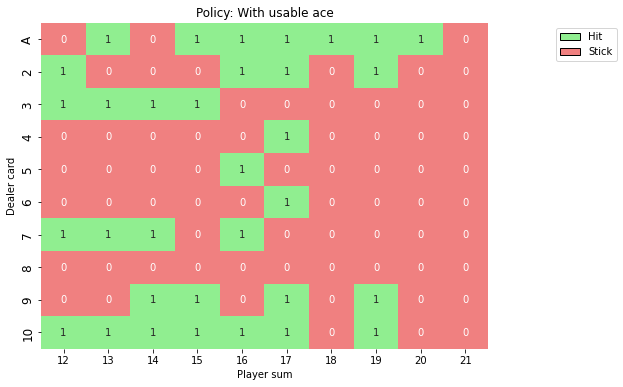

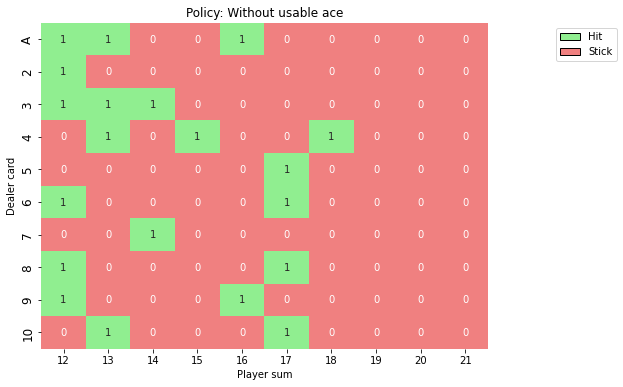

In [13]:
use_ace = True
policy_grid = create_grids(q_values, use_ace)
create_plots(policy_grid, titles="With usable ace")

use_ace = False
policy_grid = create_grids(q_values, use_ace)
create_plots(policy_grid, titles="Without usable ace")


In [14]:
def run_iterations(env, episodes, q_values, num_iterations):
    total_win = 0
    win_list = []

    for _ in range(num_iterations):
        win_rate = test_policy(env, q_values, episodes)
        total_win += win_rate[0]
        win_list.append(win_rate[0])
        print("{} of {} actions completed...".format(_ + 1, num_iterations))

    avg_win_rate = total_win / num_iterations

    print('Average win rate: {:.2f}%'.format(avg_win_rate * 100))
    print(win_list)
    
episodes = 1_000_000
num_itterations = 10

run_iterations(env, episodes, q_values, num_itterations)

Tested on 1000 episodes
Win rate: 39.60%
Loss rate: 55.10%
Average reward: -0.15
1 of 10 actions completed...
Tested on 1000 episodes
Win rate: 41.20%
Loss rate: 50.00%
Average reward: -0.09
2 of 10 actions completed...
Tested on 1000 episodes
Win rate: 42.60%
Loss rate: 50.80%
Average reward: -0.08
3 of 10 actions completed...
Tested on 1000 episodes
Win rate: 40.30%
Loss rate: 53.70%
Average reward: -0.13
4 of 10 actions completed...
Tested on 1000 episodes
Win rate: 41.20%
Loss rate: 52.10%
Average reward: -0.11
5 of 10 actions completed...
Tested on 1000 episodes
Win rate: 38.70%
Loss rate: 53.90%
Average reward: -0.15
6 of 10 actions completed...
Tested on 1000 episodes
Win rate: 38.00%
Loss rate: 56.40%
Average reward: -0.18
7 of 10 actions completed...
Tested on 1000 episodes
Win rate: 38.70%
Loss rate: 56.00%
Average reward: -0.17
8 of 10 actions completed...
Tested on 1000 episodes
Win rate: 41.20%
Loss rate: 52.20%
Average reward: -0.11
9 of 10 actions completed...
Tested on 